In [ ]:
import os
import keras
import IPython
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
# Deep learning libraries
import keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Setting seeds for reproducibility
seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)


In [ ]:
input_path = '/content/drive/My Drive/DataDiplom'

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for st in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + '/' + st + '/NORMAL'))
    n_infect = len(os.listdir(input_path + '/' + st + '/PNEUMONIA'))
    n_covid = len(os.listdir(input_path + '/' + st + '/COVID'))
    print('Set: {}, normal images: {}, pneumonia images: {}, covid images: {}'.format(st, n_normal, n_infect, n_covid))

Set: train, normal images: 8153, pneumonia images: 3418, covid images: 4729
Set: val, normal images: 511, pneumonia images: 212, covid images: 183
Set: test, normal images: 1428, pneumonia images: 640, covid images: 743


In [ ]:
def change_contrast(img):
    return tf.image.adjust_contrast(img, 1.5)

In [ ]:
def process_data(img_dims, batch_size):
    train_datagen = ImageDataGenerator(rotation_range=20, 
                                       rescale=1./255, 
                                       zoom_range=0.15, 
                                       #vertical_flip=True, 
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.15)
                                       #preprocessing_function=change_contrast)
    
    test_val_datagen = ImageDataGenerator(rescale=1./255)
                                          #preprocessing_function=change_contrast)
    
    train_gen = train_datagen.flow_from_directory(directory=input_path+ '/' + 'train', 
                                                  target_size=(img_dims, img_dims), 
                                                  batch_size=batch_size, 
                                                  class_mode='categorical', 
                                                  shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(directory=input_path+ '/' + 'val', 
                                                    target_size=(img_dims, img_dims), 
                                                    batch_size=batch_size, 
                                                    class_mode='categorical', 
                                                    shuffle=True)
    
    test_data = []
    test_labels = []

    for cond in ['/COVID/', '/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + '/' + 'test' + cond)):
            img = cv2.imread(input_path+ '/' + 'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            #img = change_contrast(img)
            if cond=='/NORMAL/':
                label = 1
            elif cond=='/PNEUMONIA/':
                label = 2
            elif cond=='/COVID/':
                label = 0
            test_data.append(img)
            test_labels.append(label)
    test_data = np.array(test_data) / 255.0
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [ ]:
img_dims = 224
epochs = 20
batch_size = 64

# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 16300 images belonging to 3 classes.
Found 906 images belonging to 3 classes.


In [ ]:
base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_dims, img_dims, 3), pooling=None)
base_model.trainable = False
initializer = tf.keras.initializers.he_normal(seed=32)
head_model = base_model.output
head_model = Flatten()(head_model)
head_model = Dense(512, activation='relu', kernel_initializer=initializer)(head_model)
head_model = Dropout(0.3)(head_model)
head_model = BatchNormalization()(head_model)
head_model = Dense(256, activation='relu', kernel_initializer=initializer)(head_model)
head_model = Dropout(0.2)(head_model)
head_model = BatchNormalization()(head_model)
predictions = Dense(3, activation='softmax', kernel_initializer=initializer)(head_model)
model = tf.keras.Model(base_model.input, outputs=predictions)
opt = Adam(learning_rate=1e-2)
class_weight = {1: 1.0,
               2: 2.4,
                0: 1.8}
es = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.05, patience=2)
lr_reduce = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=2)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
model.summary()

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

In [ ]:
!git clone https://github.com/WittmannF/LRFinder.git
from LRFinder.keras_callback import LRFinder

Cloning into 'LRFinder'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (71/71), done.


In [ ]:
lr_finder = LRFinder(min_lr=1e-4, max_lr=1)

In [ ]:
checkpoint = ModelCheckpoint("best1stage224contrast.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

Epoch 1/3
254/254 [==============================] - 412s 2s/step - loss: 1.1947 - accuracy: 0.6694
Epoch 2/3
254/254 [==============================] - 395s 2s/step - loss: 1.2055 - accuracy: 0.6820
Epoch 3/3
254/254 [==============================] - 396s 2s/step - loss: 4.7779 - accuracy: 0.6119


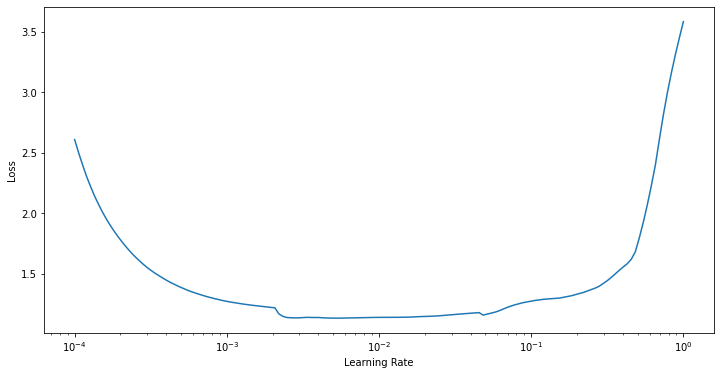

In [ ]:
history = model.fit(
            train_gen, steps_per_epoch=train_gen.samples // batch_size, 
            epochs=3, callbacks=[lr_finder],
            class_weight=class_weight)

In [ ]:
#model = keras.models.load_model('/content/drive/My Drive/Diplom96nevBN224contrast')

In [ ]:
history = model.fit(
            train_gen, steps_per_epoch=train_gen.samples // batch_size,
            epochs=10,
            class_weight=class_weight)

Epoch 1/10
254/254 [==============================] - 12451s 49s/step - loss: 0.4883 - accuracy: 0.8634
Epoch 2/10
254/254 [==============================] - 339s 1s/step - loss: 0.3272 - accuracy: 0.9077
Epoch 3/10
254/254 [==============================] - 339s 1s/step - loss: 0.2888 - accuracy: 0.9204
Epoch 4/10
254/254 [==============================] - 339s 1s/step - loss: 0.2736 - accuracy: 0.9230
Epoch 5/10
254/254 [==============================] - 338s 1s/step - loss: 0.2541 - accuracy: 0.9286
Epoch 6/10
254/254 [==============================] - 339s 1s/step - loss: 0.2475 - accuracy: 0.9314
Epoch 7/10
254/254 [==============================] - 338s 1s/step - loss: 0.2442 - accuracy: 0.9319
Epoch 8/10
254/254 [==============================] - 339s 1s/step - loss: 0.2346 - accuracy: 0.9346
Epoch 9/10
254/254 [==============================] - 338s 1s/step - loss: 0.2256 - accuracy: 0.9355
Epoch 10/10
254/254 [==============================] - 340s 1s/step - loss: 0.2293 - acc

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


KeyError: ignored

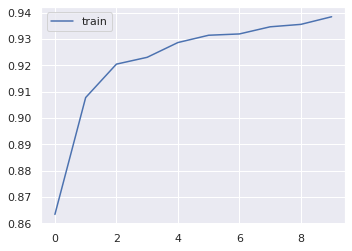

In [ ]:
import seaborn as sns
from matplotlib import pyplot
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_1.png')
pyplot.show()

In [ ]:
#model.save("/content/drive/My Drive/Diplom96nevBN224contrast")

In [ ]:
#model = keras.models.load_model('/content/drive/My Drive/Diplom96nevBN')

In [ ]:
predIdxs = model.predict(test_data)
predIdxs = np.argmax(predIdxs,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(test_labels, predIdxs, labels =[0, 1, 2])
print(cm.shape)
print(cm)

(3, 3)
[[ 631  108    4]
 [  81 1346    1]
 [   1    0  639]]


In [ ]:
#model.save("/content/drive/My Drive/Diplom96nevBN")

In [ ]:
tp_normal = cm[1][1]
tp_pneumonia = cm[2][2]
tp_covid = cm[0][0]

fn_normal = cm[1][0] + cm[1][2]
fn_pneumonia = cm[2][0] + cm[2][1]
fn_covid = cm[0][1] + cm[0][2]

fp_normal = cm[0][1] + cm[2][1]
fp_pneumonia = cm[0][2] + cm[1][2]
fp_covid = cm[1][0] + cm[2][0]

precision_normal = tp_normal/(tp_normal+fp_normal)*100
precision_pneumonia = tp_pneumonia/(tp_pneumonia+fp_pneumonia)*100
precision_covid = tp_covid/(tp_covid+fp_covid)*100

recall_normal = tp_normal/(tp_normal+fn_normal)*100
recall_pneumonia = tp_pneumonia/(tp_pneumonia+fn_pneumonia)*100
recall_covid = tp_covid/(tp_covid+fn_covid)*100

print('Precision NORMAL: {}%'.format(precision_normal))
print('Recall NORMAL: {}%'.format(recall_normal))
print('F1-score NORMAL: {}'.format(2*precision_normal*recall_normal/(precision_normal+recall_normal)))
print()
print('Precision PNEUMONIA: {}%'.format(precision_pneumonia))
print('Recall PNEUMONIA: {}%'.format(recall_pneumonia))
print('F1-score PNEUMONIA: {}'.format(2*precision_pneumonia*recall_pneumonia/(precision_pneumonia+recall_pneumonia)))
print()
print('Precision COVID: {}%'.format(precision_covid))
print('Recall COVID: {}%'.format(recall_covid))
print('F1-score COVID: {}'.format(2*precision_covid*recall_covid/(precision_covid+recall_covid)))

Precision NORMAL: 92.57221458046767%
Recall NORMAL: 94.25770308123249%
F1-score NORMAL: 93.40735600277584

Precision PNEUMONIA: 99.22360248447205%
Recall PNEUMONIA: 99.84375%
F1-score PNEUMONIA: 99.53271028037383

Precision COVID: 88.49929873772791%
Recall COVID: 84.92597577388963%
F1-score COVID: 86.67582417582418


In [ ]:
#model.save("/content/drive/My Drive/Diplom96nev")

In [ ]:
history = model.fit(
            train_gen, steps_per_epoch=train_gen.samples // batch_size, 
            epochs=3, callbacks=[lr_finder],
            class_weight=class_weight)

In [ ]:
model.trainable = True
for layer in model.layers:
  layer.trainable = True
for layer in model.layers:
  if 'conv3' in layer.name:
    break
  else:
    layer.trainable = False
epochs = 10
model.compile(optimizer=Adam(learning_rate = 1e-3),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
opt = Adam(learning_rate=1e-3)
class_weight = {1: 1.0,
               2: 2.4,
                0: 1.8}
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.01, patience=2)
lr_reduce = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=2)

In [ ]:
history = model.fit(
            train_gen, steps_per_epoch=train_gen.samples // batch_size, 
            epochs=10, validation_data=test_gen, 
            validation_steps=test_gen.samples // batch_size, callbacks=[lr_reduce],
            class_weight=class_weight)

Epoch 1/10
254/254 [==============================] - 468s 2s/step - loss: 0.0882 - accuracy: 0.9771 - val_loss: 0.0504 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 2/10
254/254 [==============================] - 466s 2s/step - loss: 0.0821 - accuracy: 0.9789 - val_loss: 0.0673 - val_accuracy: 0.9764 - lr: 0.0010
Epoch 3/10
254/254 [==============================] - 468s 2s/step - loss: 0.0804 - accuracy: 0.9783 - val_loss: 0.5161 - val_accuracy: 0.7998 - lr: 0.0010
Epoch 4/10
254/254 [==============================] - 467s 2s/step - loss: 0.0722 - accuracy: 0.9811 - val_loss: 0.2873 - val_accuracy: 0.9004 - lr: 0.0010
Epoch 5/10
254/254 [==============================] - 467s 2s/step - loss: 0.0660 - accuracy: 0.9823 - val_loss: 0.1378 - val_accuracy: 0.9448 - lr: 0.0010
Epoch 6/10
254/254 [==============================] - 460s 2s/step - loss: 0.0667 - accuracy: 0.9832 - val_loss: 0.0947 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 7/10
254/254 [==============================] - 457s 2s/st

In [ ]:
predIdxs = model.predict(test_data)
predIdxs = np.argmax(predIdxs,axis=1)

In [ ]:
cm=confusion_matrix(test_labels, predIdxs, labels =[0, 1, 2])
print(cm.shape)
print(cm)

(3, 3)
[[ 680   52   11]
 [  25 1403    0]
 [   0    0  640]]


In [ ]:
tp_normal = cm[1][1]
tp_pneumonia = cm[2][2]
tp_covid = cm[0][0]

fn_normal = cm[1][0] + cm[1][2]
fn_pneumonia = cm[2][0] + cm[2][1]
fn_covid = cm[0][1] + cm[0][2]

fp_normal = cm[0][1] + cm[2][1]
fp_pneumonia = cm[0][2] + cm[1][2]
fp_covid = cm[1][0] + cm[2][0]

precision_normal = tp_normal/(tp_normal+fp_normal)*100
precision_pneumonia = tp_pneumonia/(tp_pneumonia+fp_pneumonia)*100
precision_covid = tp_covid/(tp_covid+fp_covid)*100

recall_normal = tp_normal/(tp_normal+fn_normal)*100
recall_pneumonia = tp_pneumonia/(tp_pneumonia+fn_pneumonia)*100
recall_covid = tp_covid/(tp_covid+fn_covid)*100

print('Precision NORMAL: {}%'.format(precision_normal))
print('Recall NORMAL: {}%'.format(recall_normal))
print('F1-score NORMAL: {}'.format(2*precision_normal*recall_normal/(precision_normal+recall_normal)))
print()
print('Precision PNEUMONIA: {}%'.format(precision_pneumonia))
print('Recall PNEUMONIA: {}%'.format(recall_pneumonia))
print('F1-score PNEUMONIA: {}'.format(2*precision_pneumonia*recall_pneumonia/(precision_pneumonia+recall_pneumonia)))
print()
print('Precision COVID: {}%'.format(precision_covid))
print('Recall COVID: {}%'.format(recall_covid))
print('F1-score COVID: {}'.format(2*precision_covid*recall_covid/(precision_covid+recall_covid)))

Precision NORMAL: 96.42611683848797%
Recall NORMAL: 98.24929971988794%
F1-score NORMAL: 97.32917100242803

Precision PNEUMONIA: 98.31029185867895%
Recall PNEUMONIA: 100.0%
F1-score PNEUMONIA: 99.14794732765297

Precision COVID: 96.45390070921985%
Recall COVID: 91.52086137281292%
F1-score COVID: 93.92265193370163


In [ ]:
#model.save("/content/drive/My Drive/Diplom96nevBN224contrast")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Diplom96nevBN224contrast/assets


In [ ]:
#model.save("/content/drive/My Drive/Diplom96nevG2")

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/Diplom96nevBN224')

In [ ]:
predIdxs = model.predict(test_data)
predIdxs = np.argmax(predIdxs,axis=1)

In [ ]:
cm=confusion_matrix(test_labels, predIdxs, labels =[0, 1, 2])
print(cm.shape)
print(cm)

(3, 3)
[[ 728   10    5]
 [   4 1424    0]
 [   0    0  640]]


In [ ]:
tp_normal = cm[1][1]
tp_pneumonia = cm[2][2]
tp_covid = cm[0][0]

fn_normal = cm[1][0] + cm[1][2]
fn_pneumonia = cm[2][0] + cm[2][1]
fn_covid = cm[0][1] + cm[0][2]

fp_normal = cm[0][1] + cm[2][1]
fp_pneumonia = cm[0][2] + cm[1][2]
fp_covid = cm[1][0] + cm[2][0]

precision_normal = tp_normal/(tp_normal+fp_normal)*100
precision_pneumonia = tp_pneumonia/(tp_pneumonia+fp_pneumonia)*100
precision_covid = tp_covid/(tp_covid+fp_covid)*100

recall_normal = tp_normal/(tp_normal+fn_normal)*100
recall_pneumonia = tp_pneumonia/(tp_pneumonia+fn_pneumonia)*100
recall_covid = tp_covid/(tp_covid+fn_covid)*100

print('Precision NORMAL: {}%'.format(precision_normal))
print('Recall NORMAL: {}%'.format(recall_normal))
print('F1-score NORMAL: {}'.format(2*precision_normal*recall_normal/(precision_normal+recall_normal)))
print()
print('Precision PNEUMONIA: {}%'.format(precision_pneumonia))
print('Recall PNEUMONIA: {}%'.format(recall_pneumonia))
print('F1-score PNEUMONIA: {}'.format(2*precision_pneumonia*recall_pneumonia/(precision_pneumonia+recall_pneumonia)))
print()
print('Precision COVID: {}%'.format(precision_covid))
print('Recall COVID: {}%'.format(recall_covid))
print('F1-score COVID: {}'.format(2*precision_covid*recall_covid/(precision_covid+recall_covid)))
print()
print('Accuracy NORMAL: {}%'.format(100*cm[1][1]/1428))
print('Accuracy PNEUMONIA: {}%'.format(100*cm[2][2]/640))
print('Accuracy COVID: {}%'.format(100*cm[0][0]/743))

Precision NORMAL: 99.30264993026499%
Recall NORMAL: 99.71988795518207%
F1-score NORMAL: 99.5108315863033

Precision PNEUMONIA: 99.2248062015504%
Recall PNEUMONIA: 100.0%
F1-score PNEUMONIA: 99.61089494163426

Precision COVID: 99.4535519125683%
Recall COVID: 97.98115746971736%
F1-score COVID: 98.71186440677965

Accuracy NORMAL: 99.71988795518207%
Accuracy PNEUMONIA: 100.0%
Accuracy COVID: 97.98115746971736%


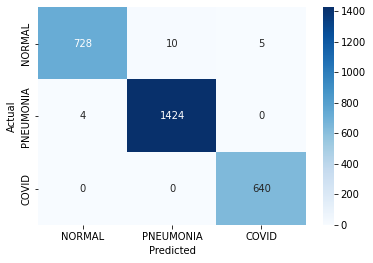

In [ ]:
import seaborn as sns
ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA", "COVID"], yticklabels=["NORMAL", "PNEUMONIA", "COVID"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

In [ ]:
def process_data2(img_dims, batch_size):
    # Data generation objects
    test_data = []
    test_labels = []
    #, '/NORMAL/', '/PNEUMONIA/'
    for cond in ['/COVID/', '/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + '/' + 'test' + cond)):
            img = cv2.imread(input_path+ '/' + 'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            #img = change_contrast(img)
            if cond=='/NORMAL/':
                label = 1
            elif cond=='/PNEUMONIA/':
                label = 2
            elif cond=='/COVID/':
                label = 0
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data) / 255.0
    test_labels = np.array(test_labels)
    
    return test_data, test_labels

In [ ]:
img_dims = 224
test_data, test_labels = process_data2(img_dims, 64)

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/Diplom96nevBN224')

In [ ]:
pip install lime

In [ ]:
from keras.applications.imagenet_utils import decode_predictions

In [ ]:
preds = model.predict(test_data)

In [ ]:
predIdxs = np.argmax(preds,axis=1)

In [ ]:
cm=confusion_matrix(test_labels, predIdxs, labels = [0, 1, 2])
print(cm.shape)
print(cm)

(3, 3)
[[ 728   10    5]
 [   4 1424    0]
 [   0    0  640]]


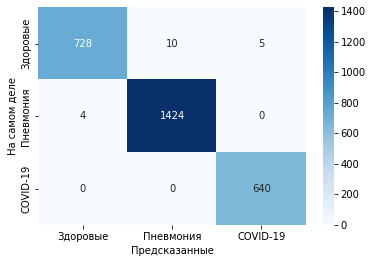

In [ ]:
import seaborn as sns
ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=["Здоровые", "Пневмония", "COVID-19"], yticklabels=["Здоровые", "Пневмония", "COVID-19"])
ax.set_xlabel('Предсказанные')
ax.set_ylabel('На самом деле');

In [ ]:
from skimage.segmentation import mark_boundaries

In [ ]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(test_data[3], model.predict, hide_color=0, num_samples=1000)

In [ ]:
temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp ,mask))